# Creating an 850mb multi-panel plot

This notebook will walk you through creating an easily customizable multi-panel 850mb plot with RAP 850mb winds and isotherms, Multi-Radar Multi-Sensor (MRMS) products and LMA points plotted.

**Created by: Ezekiel Caldon (SUNY Oswego) as part of the Lake-Effect Electrification (NSF-LEE) Project, funded by the National Science Foundation, grant number 2212177**

**Parts of code used and modified with permission from Dr. Eric Bruning (Texas Tech), Dr. Vanna Chmielewski (NSSL) & Dr. Jake Mulholland (SUNY Albany)**

## Import packages and map features and configure color maps...

<span style="color: red;">*Make sure to install the associated conda environment and use it when running this notebook.*</span>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.gridspec as gridspec
import glob
import datetime as dt
from metpy.plots import USCOUNTIES
import os
import pickle
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import xarray as xr
import shutil
import gzip
import cfgrib
import warnings
import requests
import cmweather

warnings.simplefilter(action='ignore', category=FutureWarning)
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m',
    facecolor='none',linewidth=5)
s3=boto3.client('s3', config=Config(signature_version=UNSIGNED))

# Gives an additional option for ZDR color map
colors1 = plt.cm.binary_r(np.linspace(0.,0.8,33))
colors2= plt.cm.gist_ncar(np.linspace(0.,1,100))
colors = np.vstack((colors1, colors2[10:121]))
zdrcolors = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

## Customize your plot... 

### Specify the geographical area, times, titles, of your subplots, customize the number of columns and rows and the save location for the figure, and add markers... 

In [2]:
data_area = [46, -80, 42, -74] # North lat, West lon, South lat, East lon to plot in all subplots
times = [dt.datetime(2022,11,17,8,0), # Time for each subplot. This will be the midpoint for any LMA datasets used.
         dt.datetime(2022,11,17,12,15), # The closest MRMS file to the time will be plotted.
         dt.datetime(2022,11,18,9,17), 
         dt.datetime(2022,11,18,15,50),
         dt.datetime(2022,11,18,22,0),
         dt.datetime(2022,11,18,23,0),
         dt.datetime(2022,11,19,1,0),
         dt.datetime(2022,11,19,9,0),
         dt.datetime(2022,11,19,20,0)]
titles=['Event 1', 'Event 1', 'Event 2', 'Event 2', 'IOP2', 'IOP2', 'IOP2', 'Event 3', 'Event 3'] # Title for each subplot. The time for the subplot is automatically added after this title.
num_col = 3 # Number of columns for subplot cells
num_rows = 3 # Number of rows for subplot cells

# Add markers for locations of interest on all of your subplots
num_markers = 2
marker_lat = [43.4553, 43.80164]
marker_lon = [-76.5105, -75.605755]
marker_shapes = ['o', '*']
marker_colors = ['black', 'black']
marker_sizes = [8,8]

# Directory to save the finished figure to, make sure there's a slash at the end!
show_dpi = 100 
save_dpi = 500
save_fig = False # Toggle saving the figure. Saves time if debugging since drawing 500 dpi figure takes ~2 minutes
save_dir = '/Users/zeke/oswego/research_projects/lee/Code/850mb_plots/figures/'

### Toggle the Multi-Radar Multi-Sensor (MRMS) layer, and specify fields, color maps and more...

Enable the MRMS layer to display data from NSSL's [Multi-Radar Multi-Sensor database](https://mrms.nssl.noaa.gov). MRMS files will download automatically from AWS S3 into a directory named `mrms`. This directory will be automatically created in the directory your notebook is in, if it doesn't exist already.

There are over 200 different fields that can be plotted using the MRMS database, [this directory in the AWS S3 bucket shows all of the options.](https://noaa-mrms-pds.s3.amazonaws.com/index.html#CONUS/) Copy the name of the directory without the slash in the `fields` list to utilize the desired field.

[Guidance for choosing a colormap from cmweather,](https://cmweather.readthedocs.io/en/latest/api.html) which has been imported, and will likely have the most useful colormaps, including color-blind friendly options.

[Guidance for choosing a colormap from MatPlotLib;](https://arm-doe.github.io/pyart/examples/plotting/plot_choose_a_colormap.html) this is verbose and doesn't contain many colormaps useful for MRMS products, but may be helpful if you don't find what you're looking for in cmweather.

`zdrcolors` has been initialized in the import statements as a good *Z<sub>DR</sub>* colormap, just add it without `String` markers to utilize.

In [3]:
mrms_on = True # Enable MRMS layer?

fields = ['MergedReflectivityQCComposite_00.50', 'MergedReflectivityQCComposite_00.50', 'MergedReflectivityQCComposite_00.50', 'MergedReflectivityQCComposite_00.50', 'MergedReflectivityQCComposite_00.50', 'MergedReflectivityQCComposite_00.50', 'MergedReflectivityQCComposite_00.50', 'MergedReflectivityQCComposite_00.50', 'MergedReflectivityQCComposite_00.50']

multi_color_bar = False # If you are plotting different  fields in each pane, toggle to True
mrms_single_axis_title = 'Reflectivity (dBZ)' # If each field is the same, put the axis title here.
radar_multi_axis_titles = ['', '', '', '', '', '', '', '', ''] # Put axis titles in this list. If you have multi_color_bar = False, leave '' placeholders for the number of subplots you have.
multi_colorbar_orientation = 'vertical'

mrms_cmap = ['HomeyerRainbow', 'HomeyerRainbow', 'HomeyerRainbow', 'HomeyerRainbow', 'HomeyerRainbow', 'HomeyerRainbow', 'HomeyerRainbow', 'HomeyerRainbow', 'HomeyerRainbow'] # List of color maps to be used in each subplot
value_min = 10 # Minimum value for each pane's color map
value_max = 50 # Maximum value for each pane's color map
gate_filter_num = 12 # Gate filter

time_range = 12 # Configure the time range (in minutes) that the program will search for radar images after the configured times.

### Toggle the RAP analysis layer and specify the file directory, line and wind barb options...

Enable the RAP layer to display 850mb isotherms and wind barbs on your plot.

RAP files must be downloaded manually due to the slow nature of the data access website gumming up the program. Download them into a directory on your machine and copy that directory's path to the `RAP_dir` variable. [RAP files can be downloaded here.](https://www.ncei.noaa.gov/data/rapid-refresh/access/rap-130-13km/analysis/)

The code will `pickle` the RAP data and store it as a `.pkl` file in a directory called `cache` that will be automatically created if it does not exist already. This measure helps save time when playing around with other customizations to the plot since the RAP `.grib` files take a while to process.

[For help specifying colors for MatPlotLib, go here](https://matplotlib.org/stable/users/explain/colors/colors.html#sphx-glr-users-explain-colors-colors-py).

In [4]:
# RAP
rap_on = True # Enable rap layer?

RAP_dir = '/Users/zeke/oswego/research_projects/lee/Code/850mb_plots/notebooks/rap/' # Directory with RAP files, make sure there's a slash at the end

therm_line_width = 1.5 # Width of isotherm lines
isotherm_color = 'r' # Isotherm color.
inline_tf = True # Toggle inline isotherm labels
inline_space = 1 # Isotherm inline whitespace for labels
levels = np.arange(-30,30,2) # Specify isotherm levels (min, max, step)

wind_barb_spacing = 0.2 # Spacing of barbs on wind barbs
station_spacing = 5 # Spacing of wind barb stations
wind_barb_size = 6 # Size of wind barbs

### Toggle the LMA layer and specify the file directory, filter and plotting options...

LMA `.h5` flash files are downloaded automatically to a directory named `lma` that will be automatically created in the directory that your notebook is located, if it doesn't exist already. [If you have trouble downloading with the code, the `.h5` files can be downloaded here.](https://data.nssl.noaa.gov/thredds/catalog/WRDD/OKLMA/deployments/flashsort_6/h5_files/catalog.html)

[For help specifying colors for MatPlotLib, go here](https://matplotlib.org/stable/users/explain/colors/colors.html#sphx-glr-users-explain-colors-colors-py).

[For a list of point markers for MatPlotLib, go here](https://matplotlib.org/stable/api/markers_api.html#module-matplotlib.markers)

In [5]:
lma_on = True # Enable lma layer?

min_events_per_flash = 10 # Minimum number of sources per flash
min_stations = 6 # more stations = more confident it's a good solution
max_chi = 1 # lower chi^2 = more confident it's a good solution
tbuffer = 60*60 # range for LMA data after specified time in seconds

lma_point_color = 'fuchsia' # LMA point color.
lma_point_size = 50 # LMA point size
lma_point_marker = '^' # LMA point marker.

## Setting things up and declaring functions for the plot

In [6]:
projection = ccrs.PlateCarree()
display = []
base_wid = 6
base_hei = 4
fig_wid = num_col * base_wid
fig_hei = num_rows * base_hei
bounds = np.arange(value_min, value_max, 5)

In [7]:
def plot_mrms(ax, time, cmap, num):
    if mrms_on == True:
        save_filename = f"mrms/{fields[num]}{time.strftime('%Y%m%d%H')}.grib2.gz"
        unzip_filename = save_filename[:-3]
        if (os.path.exists(unzip_filename) == False):
            # Downloads closest MRMS file from the noaa-mrms-pds AWS S3 bucket to a
            # local directory named "mrms"
            os.makedirs("mrms", exist_ok=True)
            paginator = s3.get_paginator('list_objects_v2')
            page_iterator = paginator.paginate(Bucket='noaa-mrms-pds', Prefix=f'CONUS/{fields[num]}/{time.strftime('%Y%m%d')}')
            selected_file = ''
            min_time_difference = dt.timedelta(minutes=(time_range/2))
            for page in page_iterator:
                for obj in page.get('Contents', []):
                    current_dt = dt.datetime.strptime((obj['Key'][-24:-9]), "%Y%m%d-%H%M%S")
                    if ((current_dt - time).days < 0):
                        current_time_difference = time - current_dt
                    else:
                        current_time_difference = current_dt - time
                    if (current_time_difference < min_time_difference):
                        selected_file = obj['Key']
                        min_time_difference = current_time_difference
            s3.download_file('noaa-mrms-pds', selected_file, save_filename)
            
            # Unzips the file and deletes the .zip file
            with gzip.open(save_filename, 'rb') as gz_file:
                with open(unzip_filename, 'wb') as output_file:
                    shutil.copyfileobj(gz_file, output_file)
            os.remove(save_filename)
            
        # Plots the data
        ds = cfgrib.open_dataset(unzip_filename)
        ds = ds.metpy.parse_cf()
        radar_values = list(ds.data_vars.values())[0]
        filtered_radar_values = radar_values.where(radar_values > gate_filter_num)
        cbar_kwargs = {'orientation': 'horizontal'}
        if (multi_color_bar):
            im = filtered_radar_values.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=value_min, vmax=value_max, cmap=cmap, add_colorbar=multi_color_bar, cbar_kwargs=cbar_kwargs)
        else:
            im = filtered_radar_values.plot(ax=ax, transform=ccrs.PlateCarree(), 
                                       vmin=value_min, vmax=value_max, cmap=cmap, add_colorbar=multi_color_bar)
        return im

In [8]:
def plot_rap_data(time, ax):
    if rap_on == True:
        data = get_cached_rap_data(time)
        CS = ax.contour(data["lon_t"], data["lat_t"], data["T85"], levels,
                        colors=isotherm_color, linewidths=therm_line_width,
                        transform=ccrs.PlateCarree())
        ax.clabel(CS, fontsize=12, fmt="%1.0f", inline=inline_tf, inline_spacing=inline_space)
        ax.barbs(data["lon_u"][::station_spacing, ::station_spacing], data["lat_u"][::station_spacing, ::station_spacing],
                 data["U85"][::station_spacing, ::station_spacing], data["V85"][::station_spacing, ::station_spacing],
                 transform=ccrs.PlateCarree(),
                 sizes=dict(emptybarb=0.1, spacing=wind_barb_spacing, height=0.35),
                 length=wind_barb_size, flip_barb=False, zorder=1)

def get_cached_rap_data(time):
    pickle_path = f"cache/rap_{time:%Y%m%d%H}-{data_area[0]}{360+data_area[1]}{data_area[2]}{360+data_area[3]}.pkl"
    lat_max, lon_min, lat_min, lon_max = data_area
    lon_min = lon_min+360
    lon_max = lon_max+360
    
    if os.path.exists(pickle_path):
        with open(pickle_path, "rb") as f:
            return pickle.load(f)
    
    filename = glob.glob(f"{RAP_dir}r*{time.strftime('%Y%m%d_%H')}00_000.grb2")
    if not filename:
        filename = glob.glob(f"{RAP_dir}r*{(time + dt.timedelta(hours=1)).strftime('%Y%m%d_%H')}00_000.grb2")
    if not filename:
        raise FileNotFoundError("RAP file not found for time " + str(time))
    
    ds = xr.open_dataset(filename[0], engine='cfgrib', filter_by_keys={'typeOfLevel':'isobaricInhPa', 'level': 850}, backend_kwargs={"indexpath": ""})
   
    level = 850
    T85 = ds['t'].sel() - 273.15
    U85 = ds['u'].sel()
    V85 = ds['v'].sel()
    
    lat = ds['latitude']
    lon = ds['longitude']

    mask = (lat >= lat_min) & (lat <= lat_max) & (lon >= lon_min) & (lon <= lon_max)
    
    T85_masked = T85.where(mask, np.nan).values
    U85_masked = U85.where(mask, np.nan).values
    V85_masked = V85.where(mask, np.nan).values  

    result = {
        "T85": T85_masked,
        "U85": U85_masked,
        "V85": V85_masked,
        "lat_u": lat.values,
        "lon_u": lon.values,
        "lat_t": lat.values,
        "lon_t": lon.values
    }

    os.makedirs('cache', exist_ok=True)
    with open(pickle_path, "wb") as f:
        pickle.dump(result, f)
        
    return result  

In [9]:
def plot_LMA_flash_data(start):
    if lma_on == True:
        filenames = []
        flashes = []
        flash_event_time = []
        flash_events = []
        selection_event = []
        lma_lon = []
        lma_lat = []
        os.makedirs('lma', exist_ok=True)
        filename = 'lma/LYLOUT_{}000_0600.dat.flash.h5'.format(start.strftime('%y%m%d_%H%M')[:-1])
        filenames.append(filename)
        if (glob.glob(filename) == []):
            url = 'https://data.nssl.noaa.gov/thredds/fileServer/WRDD/OKLMA/deployments/flashsort_6/h5_files/{}/{}'.format(start.strftime('%Y/%m/%d'),filename[4:])
            response = requests.get(url)
            with open(filename, "wb") as file:
                file.write(response.content)
            print(f'{filename} downloaded successfully.')
        if (tbuffer > 600):
            for i in range(int(tbuffer/600)):
                filename = 'lma/LYLOUT_{}000_0600.dat.flash.h5'.format((start+dt.timedelta(seconds=(i*600))).strftime('%y%m%d_%H%M')[:-1])
                filenames.append(filename)
                if (glob.glob(filename) == []):
                    url = 'https://data.nssl.noaa.gov/thredds/fileServer/WRDD/OKLMA/deployments/flashsort_6/h5_files/{}/{}'.format((start+(dt.timedelta(seconds=(i*600)))).strftime('%Y/%m/%d'),filename[4:])
                    response = requests.get(url)
                    with open(filename, "wb") as file:
                        file.write(response.content)
                    print(f'{filename} downloaded successfully.')
        filename = 'lma/LYLOUT_{}000_0600.dat.flash.h5'.format((start+dt.timedelta(seconds=tbuffer)).strftime('%y%m%d_%H%M')[:-1])
        if filename not in filenames:
            filenames.append(filename)
            if (glob.glob(filename) == []):
                    url = 'https://data.nssl.noaa.gov/thredds/fileServer/WRDD/OKLMA/deployments/flashsort_6/h5_files/{}/{}'.format((start+dt.timedelta(seconds=tbuffer)).strftime('%Y/%m/%d'),filename[4:])
                    response = requests.get(url)
                    with open(filename, "wb") as file:
                        file.write(response.content)
                    print(f'{filename} downloaded successfully.')
        flashes = pd.DataFrame()
        flash_events = pd.DataFrame()
        for filename in filenames:
            timeobj = dt.datetime.strptime(filename.split('/')[-1], 
                                           "LYLOUT_%y%m%d_%H%M%S_0600.dat.flash.h5")
            # This is the flash table
            flashes2 = pd.read_hdf(filename,'flashes/LMA_{}00_600'.format(
                                            timeobj.strftime('%y%m%d_%H%M')))
            # This is the event (VHF source) table
            flash_events2 = pd.read_hdf(filename,'events/LMA_{}00_600'.format(
                                            timeobj.strftime('%y%m%d_%H%M')))
            # Flash ID's are not unique between files. This writes new ones 
            # in the second file, if it exists
            if flashes.shape[0]>0:
                flashes2.flash_id      = flashes2['flash_id']     +flashes.flash_id.max()+1
                flash_events2.flash_id = flash_events2['flash_id']+flashes.flash_id.max()+1
            else:
                pass
            flashes      = pd.concat([flashes,flashes2])
            flash_events = pd.concat([flash_events,flash_events2])         
            
        # Make a series of datetime objects for each event
        flash_event_time = np.array([dt.datetime(*start.timetuple()[:3])+dt.timedelta(seconds = j) for j in flash_events.time])
        try:
            # Select all the sources meeting the criteria set above
            selection_event = (flash_event_time>=start)&(flash_event_time < start+dt.timedelta(seconds=tbuffer))&(flash_events.chi2<=max_chi)&(flash_events.stations>=min_stations)
            
            lma_lon = (flash_events.lon[selection_event].values)
            
            lma_lat = (flash_events.lat[selection_event].values)
        
        except AttributeError:
            pass
        try:
            # Only those in flashes and meeting criteria set above
            if flash_events.empty == False:
                for flash in flashes.flash_id[flashes.n_points>=min_events_per_flash]:
                    if (any ((flash_events.flash_id[selection_event]==flash) == True)):
                        plt.scatter(lma_lon[(flash_events.flash_id[selection_event]==flash)][0],
                                    lma_lat[(flash_events.flash_id[selection_event]==flash)][0],
                                    color=lma_point_color,s=lma_point_size,marker=lma_point_marker)
        except NameError:
            pass

## Plot code

*This part of the code may give `ECCODES error`s and `UserWarning`s in addition to notifying you of the download of LMA files. These are all normal messages and are not cause for concern.* 

It's just `cfgrib` whining about the RAP files which are admittedly not fun to work with, but it is processing and plotting them correctly.

/var/folders/gy/jfp1tdvj71z2lq5ms8m0_9qc0000gn/T/ipykernel_51360/1534323349.py:33: UserWarning: More than one time coordinate present for variable  "unknown".
  ds = ds.metpy.parse_cf()
/var/folders/gy/jfp1tdvj71z2lq5ms8m0_9qc0000gn/T/ipykernel_51360/1534323349.py:33: UserWarning: More than one time coordinate present for variable  "unknown".
  ds = ds.metpy.parse_cf()
/var/folders/gy/jfp1tdvj71z2lq5ms8m0_9qc0000gn/T/ipykernel_51360/1534323349.py:33: UserWarning: More than one time coordinate present for variable  "unknown".
  ds = ds.metpy.parse_cf()
/var/folders/gy/jfp1tdvj71z2lq5ms8m0_9qc0000gn/T/ipykernel_51360/1534323349.py:33: UserWarning: More than one time coordinate present for variable  "unknown".
  ds = ds.metpy.parse_cf()
/var/folders/gy/jfp1tdvj71z2lq5ms8m0_9qc0000gn/T/ipykernel_51360/1534323349.py:33: UserWarning: More than one time coordinate present for variable  "unknown".
  ds = ds.metpy.parse_cf()
/var/folders/gy/jfp1tdvj71z2lq5ms8m0_9qc0000gn/T/ipykernel_51360/15343

Figure saved. Will show in a few moments...


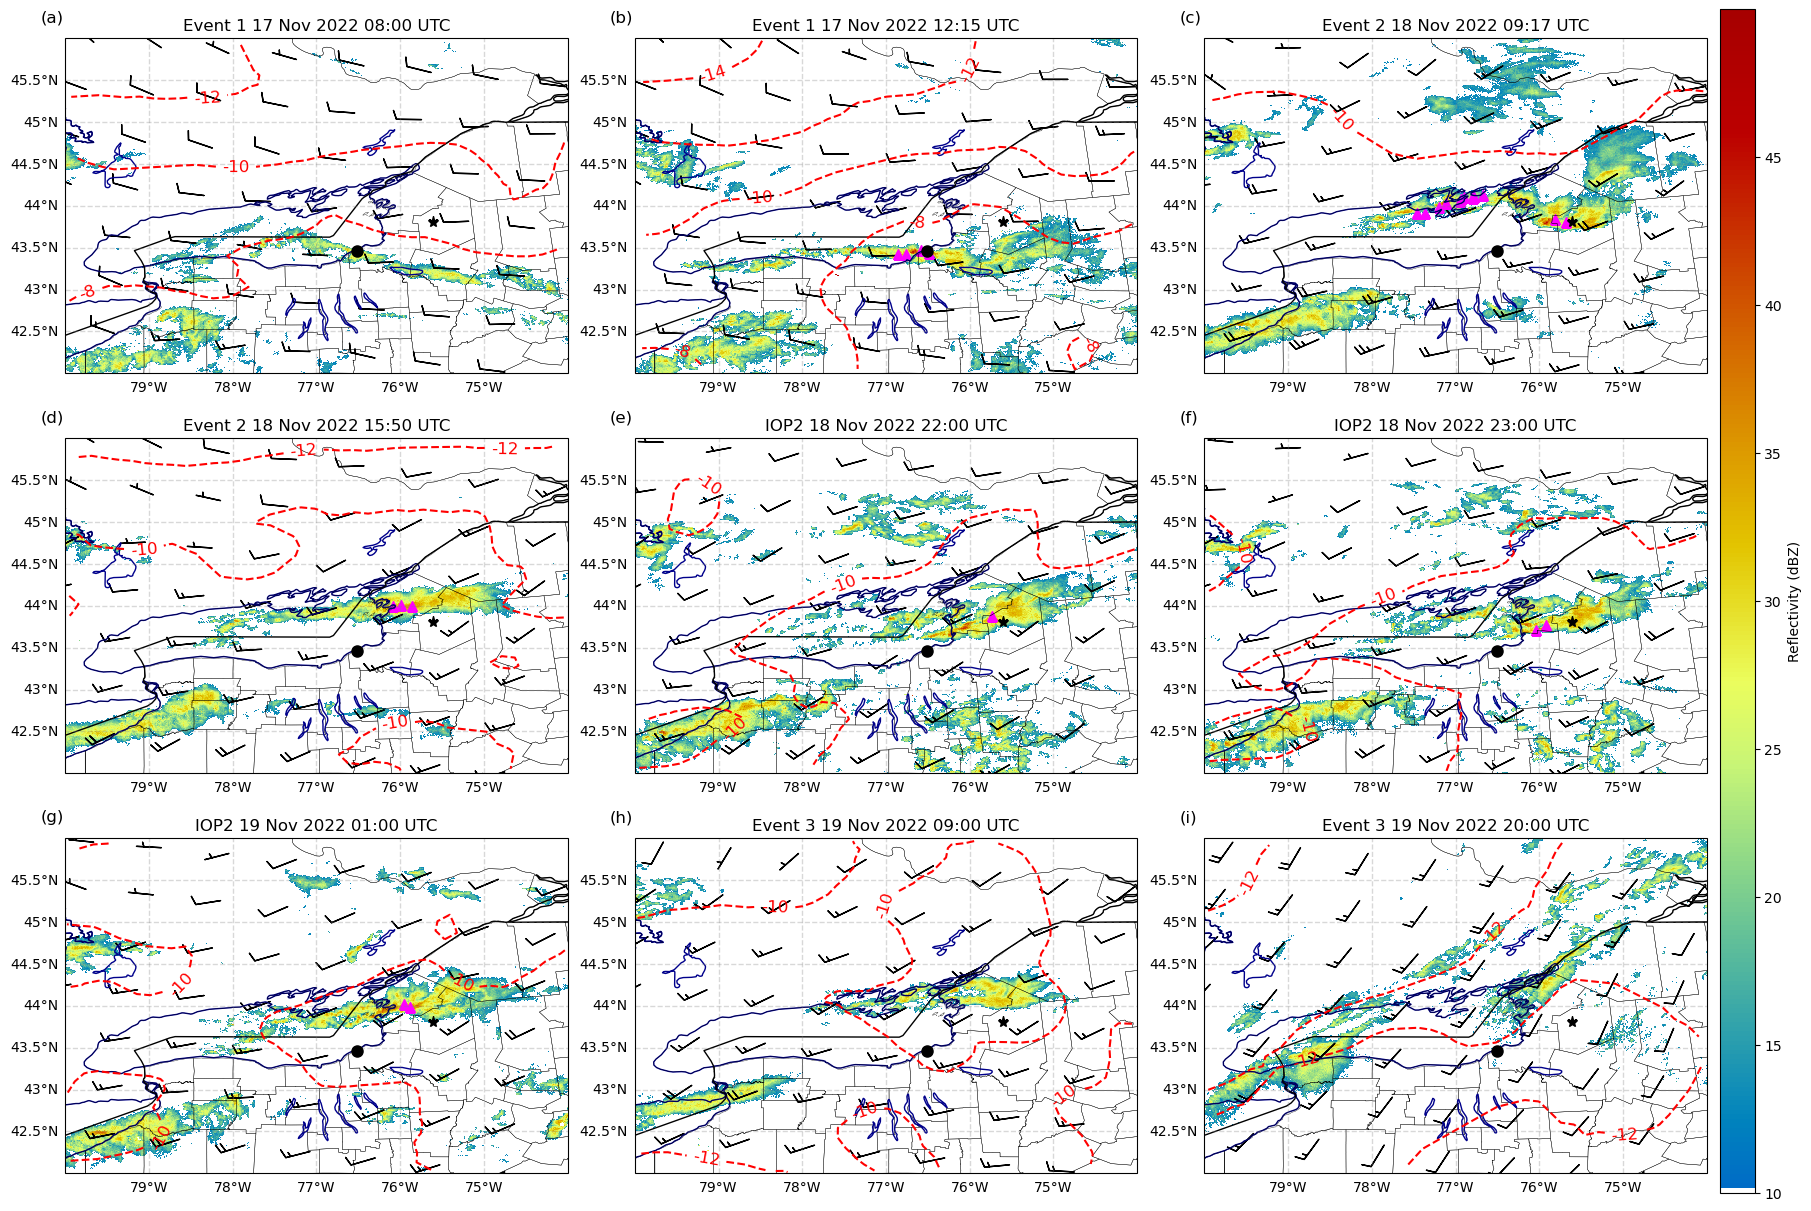

In [10]:
fig = plt.figure(figsize = (fig_wid,fig_hei), layout='constrained', dpi=show_dpi)
ax = []

gs0 = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[0.98, 0.02])
gs1 = gridspec.GridSpecFromSubplotSpec(num_rows, num_col, gs0[0])

for i in range(num_col*num_rows):
    # Define colormap
    cmap = plt.get_cmap(mrms_cmap[i])
    norm = BoundaryNorm(bounds, ncolors=cmap.N)
    
    # Add white for masked (low dBZ) values
    colors = cmap(np.linspace(0, 1, cmap.N))
    white = np.array([[1, 1, 1, 1]])  # RGBA white
    newcolors = np.vstack((white, colors))  # Add white at start
    new_cmap = ListedColormap(newcolors)
    
    # Shift norm to match new color list
    norm = BoundaryNorm(np.insert(bounds, 0, 0), new_cmap.N)
    
    ax_proj = ccrs.PlateCarree()
    ax.append(fig.add_subplot(gs1[i], projection=ax_proj))
    im = plot_mrms(ax[i], times[i], new_cmap, i)
    
    ax[i].set_title(titles[i] + ' {} UTC'.format(times[i].strftime('%d %b %Y %H:%M')))
    # Add gridlines
    gl = ax[i].gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,color="gray",alpha=0.3,linestyle="--",)
    gl.right_labels = False
    gl.top_labels = False
    
    ax[i].set_extent([data_area[1], data_area[3], data_area[2], data_area[0]], ccrs.PlateCarree())
    
    ax[i].add_feature(USCOUNTIES.with_scale('500k'), linewidth=0.25)
    ax[i].add_feature(cfeature.LAKES, facecolor='None',edgecolor='darkblue', linewidth=1)
    ax[i].add_feature(cfeature.COASTLINE,edgecolor='black',linewidth=1)
    ax[i].add_feature(cfeature.BORDERS,edgecolor='black',linewidth=1)
    ax[i].add_feature(states_provinces, edgecolor='black',linewidth=0.25)
    ax[i].add_feature(cfeature.STATES, edgecolor='black', linewidth=0.25)
    
    plot_rap_data(times[i], ax[i])
    
    plot_LMA_flash_data(times[i]-dt.timedelta(seconds = (tbuffer/2)))

    for j in range(num_markers):
        ax[i].plot(marker_lon[j], marker_lat[j], marker=marker_shapes[j], color=marker_colors[j], markersize=marker_sizes[j], transform=ccrs.PlateCarree())
    
    char = chr(97+i)
    
    ax[i].text((data_area[1]-.3),(data_area[0]+.2),'(' + char + ')', fontsize=12)


if ((mrms_on == True) & (multi_color_bar == False)):
    cbar_ax = fig.add_subplot(gs0[:, -1])
    fig.colorbar(im, cax=cbar_ax, ticks=bounds, label=mrms_single_axis_title)
# display[(num_col*num_rows)-1].plot_colorbar(field=radar_fields[0], orientation='vertical', cax=cbar_ax, fig=fig)

# plt.savefig(save_dir + '850mbplot' + times[0].strftime('%y%m%d%H') + '.png', dpi=500, facecolor='white')
if (save_fig):
    plt.savefig(save_dir + '850mbplot' + times[0].strftime('%y%m%d%H') + '.png', dpi=save_dpi, facecolor='white')
    print("Figure saved. Will show in a few moments...")

plt.show()